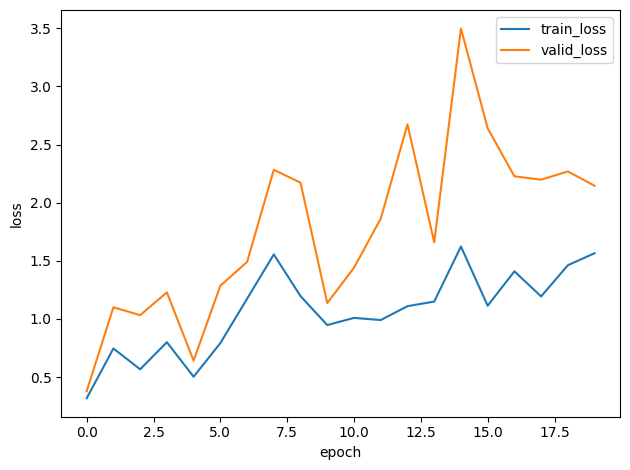

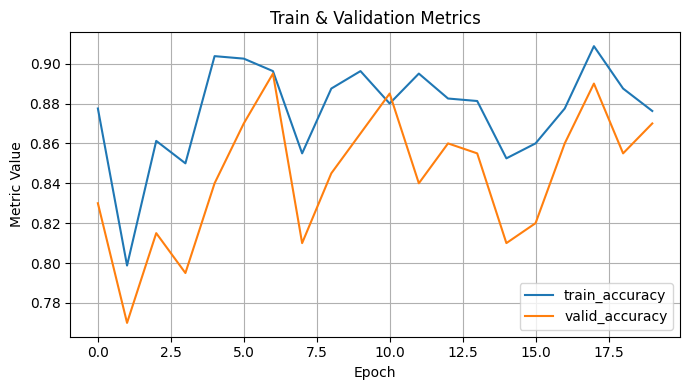

In [1]:
#CLASSIFICATION

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.metrics import Accuracy

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------------------------------------
# Dataset
# ------------------------------------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.astype(np.int64)

# ------------------------------------------------------------
# Build GA experiment (builder mode)
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .optimizer(
        "ga",
        population_size=60,
        mutation_rate=0.15,
        step_size=0.1,
    )
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=True,
        normalize=None,
    )
)

# ------------------------------------------------------------
# Train
# ------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=20,
    seed=seed,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()


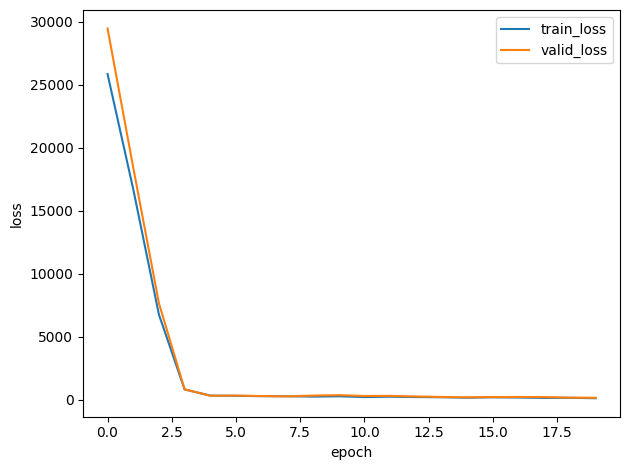

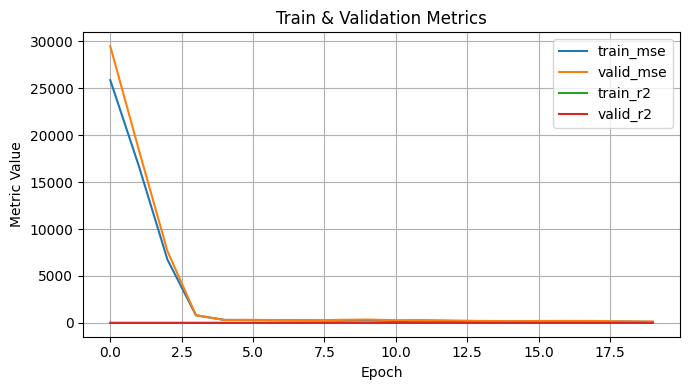

In [1]:
# REGRESSION

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import MSE, R2
from pyperch.utils import plot_losses, plot_metrics

# ------------------------------------------------------------
# Repro
# ------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------------------------------------
# Dataset
# ------------------------------------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    noise=0.2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

# ------------------------------------------------------------
# GA Regression Builder
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=1,
        activation="leaky_relu",  
    )
    .optimizer(
        "ga",
        population_size=60,
        mutation_rate=0.15,
        step_size=0.1,
    )
    .metrics(MSE(), R2())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=False,
        normalize=None,
    )
)

# ------------------------------------------------------------
# Train
# ------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=20,
    seed=seed,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Plots (Loss + Metrics)
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

Frozen layer unchanged: True


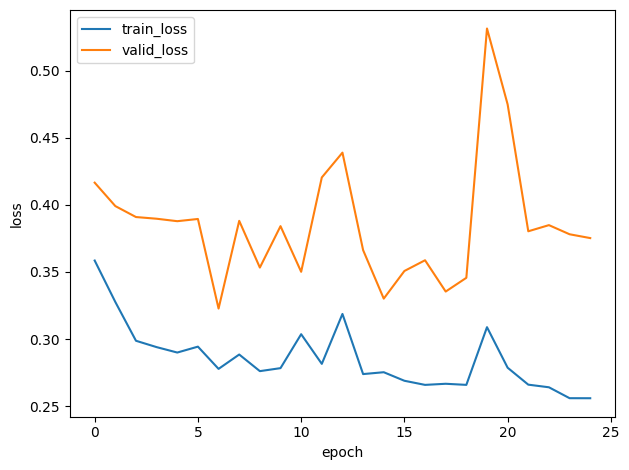

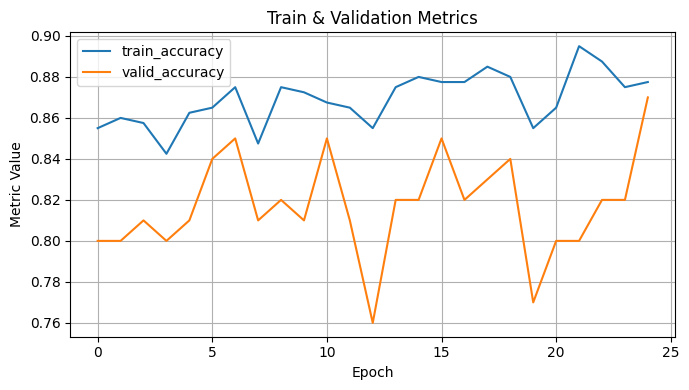

In [2]:
# FREEZING
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# -------------------------------------------------------------------
# Dummy dataset
# -------------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# -------------------------------------------------------------------
# GA Freeze experiment (builder mode)
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .freeze("net.0.weight", "net.0.bias")      # FIRST LAYER FROZEN
    .meta_opt("net.2.weight", "net.2.bias")    # LAST LAYER GA-OPTIMIZED
    .optimizer(
        "ga",
        population_size=60,
        mutation_rate=0.15,
        step_size=0.1,
    )
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# -------------------------------------------------------------------
# Capture frozen weights BEFORE training
# -------------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=25,
    seed=42,
    optimizer_mode="per_batch",
)

# -------------------------------------------------------------------
# Verify frozen layer did not change
# -------------------------------------------------------------------
initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

print("Frozen layer unchanged:", torch.allclose(initial, final))

# -------------------------------------------------------------------
# Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

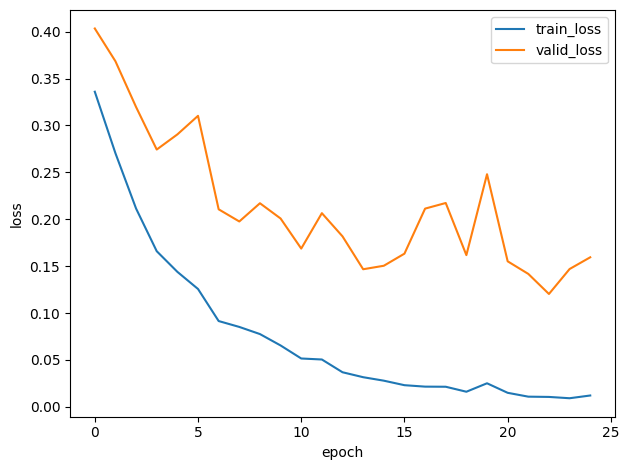

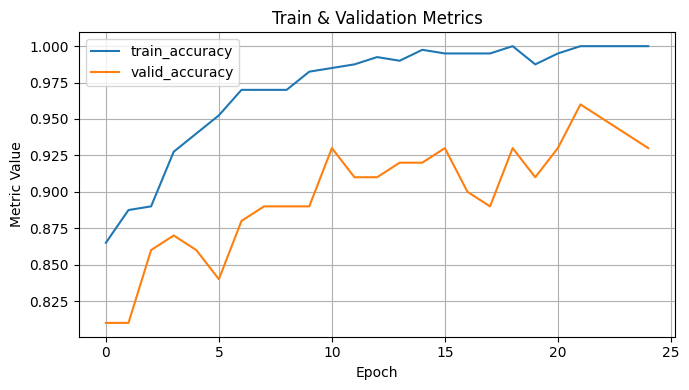

In [3]:
#hybrid test: 

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_metrics

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# GA Hybrid experiment
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # ------------------------------
    # Layer modes
    # ------------------------------
    .grad_opt("net.0.weight", "net.0.bias")     # Adam optimizer
    .meta_opt("net.2.weight", "net.2.bias")     # GA optimizer
    # ------------------------------
    # Optimizers
    # ------------------------------
    .torch_optimizer("adam", lr=1e-3)           # used on grad layers
    .optimizer(
        "ga",
        population_size=60,
        mutation_rate=0.15,
        step_size=0.1,
    )                                           # used on meta layers
    # ------------------------------
    # Metrics + Data
    # ------------------------------
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# ------------------------------------------------------------
# Train
# ------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=25,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

Frozen layer unchanged: True


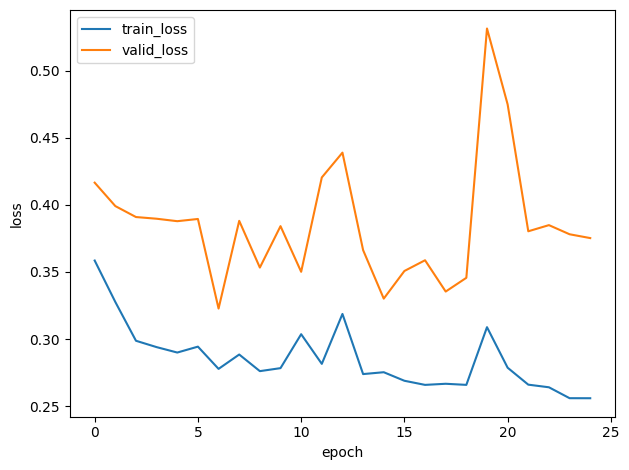

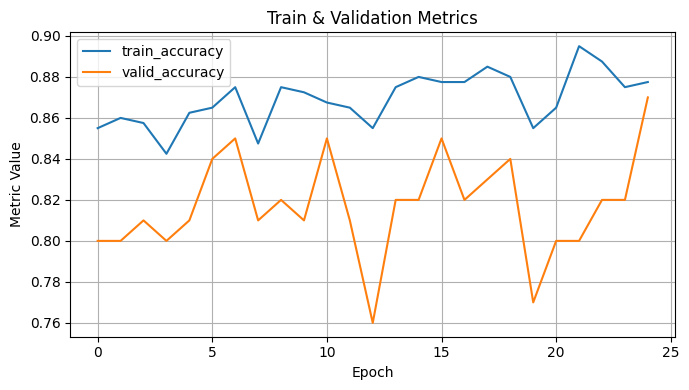

In [4]:
#freeze + hybrid
# ------------------------------------------------------------
# Freeze first layer
# Train middle with Adam
# Train output with GA
# ------------------------------------------------------------
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Build FREEZE + GA hybrid model
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # ------------------------------
    # Layer modes
    # ------------------------------
    .freeze("net.0.weight", "net.0.bias")        # FROZEN
    .meta_opt("net.2.weight", "net.2.bias")      # GA updates only these params

    # ------------------------------
    # GA optimizer (meta only)
    # ------------------------------
    .optimizer(
        "ga",
        population_size=60,
        mutation_rate=0.15,
        step_size=0.1,
    )

    # ------------------------------
    # Metrics + Data
    # ------------------------------
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# ------------------------------------------------------------
# Capture frozen layer BEFORE training
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=25,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Verify FROZEN LAYER did not change
# ------------------------------------------------------------
initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

print("Frozen layer unchanged:", torch.allclose(initial, final))

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()
